# Virtual Synthesizer

All audio is basically signal data, manipulated by functions. Synthesizers use either analog or digital signals to create unique sounds. Here I experiment with creating a digital synthesizer using python

In [6]:
import wave
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 3)
from matplotlib import pyplot as plt
from IPython.display import Audio
from collections import namedtuple

# Constants
AUDIO_FILENAME = 'data/audio.wav'
SAMPLE_RATE = 44100.0  # 44.1 kHz sample rate (the standard)
SAMPLE_TYPE = np.int16 # Using 16-bit integers for samples

First let's start with learning how to create audio from scratch. I'm going to be using .wav files, since they have no compression and are easier to understand. Python provides the 'wave' library for reading and writing wav files

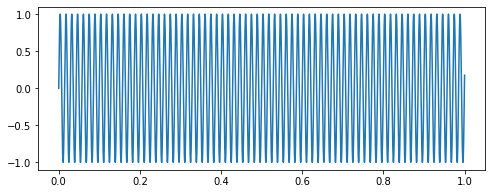

In [7]:
# Intermediary stuff
n_sample_bytes = np.iinfo(SAMPLE_TYPE).bits // 8 # Number of bytes in sample type
n_sample_max   = np.iinfo(SAMPLE_TYPE).max       # Maximum value of single sample

# Create a wave
a_freq = 440.0 # A note
duration = 1.0
t = np.linspace(0, duration, int(duration*SAMPLE_RATE))
a = np.sin(t*a_freq)

# Convert wave to binary data
b = a*n_sample_max
b = b.astype(SAMPLE_TYPE)
b = b.tobytes('C')

# Write audio
with wave.open(AUDIO_FILENAME, 'wb') as wv:
    wv.setnchannels(1)
    wv.setsampwidth(n_sample_bytes)
    wv.setframerate(SAMPLE_RATE)
    wv.writeframes(b)
    
# Display audio
plt.plot(t, a);
Audio(AUDIO_FILENAME)

Gonna clean this up and make a function out of it, take a set of data points from 0 to 1 and spit out an audio player

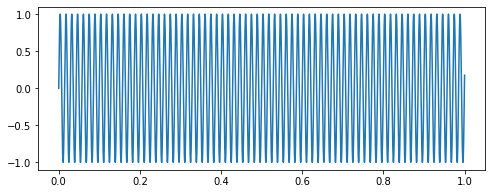

In [8]:
def play(signal, sample_rate=SAMPLE_RATE, sample_type=SAMPLE_TYPE, filename=AUDIO_FILENAME):
    """
    Play signal as audio
    """
    # Intermediary stuff
    n_sample_bytes = np.iinfo(sample_type).bits // 8 # Number of bytes in sample type
    n_sample_max   = np.iinfo(sample_type).max       # Maximum value of single sample
    
    # Convert wave to binary data
    signal_bytes = signal*n_sample_max
    signal_bytes = signal_bytes.astype(sample_type)
    signal_bytes = signal_bytes.tobytes('C')

    # Write audio
    with wave.open(filename, 'wb') as wv:
        wv.setnchannels(1)
        wv.setsampwidth(n_sample_bytes)
        wv.setframerate(sample_rate)
        wv.writeframes(signal_bytes)

    # Display audio
    return Audio(filename)


# Create a wave
a_freq = 440.0
duration = 1.0
t = np.linspace(0, duration, int(duration*SAMPLE_RATE))
a = np.sin(t*a_freq)

# Play wave
plt.plot(t, a);
play(a)

We can compose functions together to control waves. For example, we can turn a wave on and off using a step function

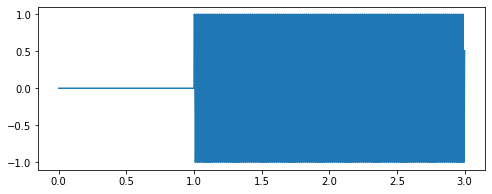

In [9]:
duration = 3.0
a_freq = 440.0
t = np.linspace(0, duration, int(duration*SAMPLE_RATE))
u = np.where(t >= 1.0, 1.0, 0.0)
a = np.sin(t*a_freq)
o = u*a

# Play audio
plt.plot(t, o);
play(o)

Create functions with parameters.

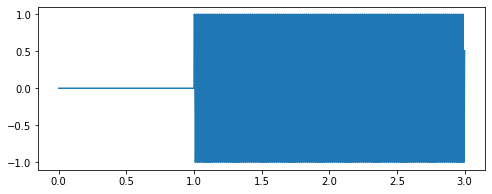

In [10]:
step = lambda start: lambda t: np.where(t >= start, 1.0, 0)
sin = lambda freq: lambda t: np.sin(t*freq)

t_space = lambda duration: np.linspace(0,
    duration,
    int(duration*SAMPLE_RATE)
)
    
# Input space
t = t_space(3.0)

# Create wave
u = step(1.0)(t)
a = sin(440.0)(t)
o = u*a

# Play audio
plt.plot(t, o);
play(o)

Modulate signal amplitude using a lower frequency sine wave

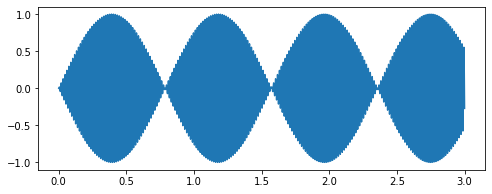

In [11]:
# Input space
t = t_space(3.0)

# Create wave
a = sin(440.0)(t)
l = sin(4)(t)
o = l*a

# Play audio
plt.plot(t, o)
play(o)

Now that sounds cool. Let's add some more notes separated by time. We can do that with a box function, with a start and end

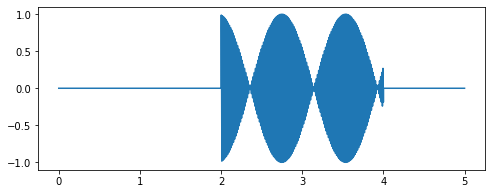

In [12]:
box = lambda start, end: lambda t: step(start)(t)*(1 - step(end)(t))

# Input space
t = t_space(5.0)

# Create wave
a = sin(440.0)(t)
l = sin(4)(t)
b = box(2, 4)(t)
o = a*l*b

# Play audio
plt.plot(t, o)
play(o)

Now we can string a bunch of these together to make multiple tones. Let's start with octaves of the note A. You can create an octave by multiplying the fundamental frequency by 2

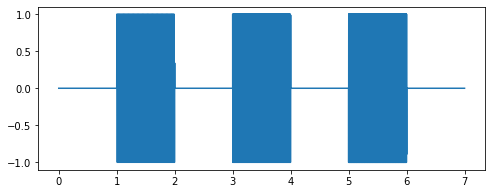

In [17]:
# Input space
t = t_space(7.0)

# Octaves
a0 = sin(440.0)(t)
b0 = box(1, 2)(t)
a1 = sin(440.0 * 2)(t)
b1 = box(3, 4)(t)
a2 = sin(440.0 * 4)(t)
b2 = box(5, 6)(t)

# Create signal
o = a0*b0 + a1*b1 + a2*b2

# Make sure we clip signal before we play it
aclip = lambda o: np.clip(o, -1, 1)
o = aclip(o)

# Play audio
plt.plot(t, o)
play(o)

Now let's write out all the note frequencies

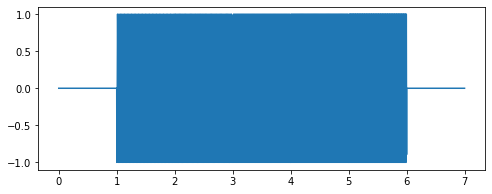

In [18]:
# Notes (_ means flat)
c  = 261.63
d_ = 277.18
d  = 293.66
e_ = 311.13
e  = 329.63
f  = 349.23
g_ = 369.99
g  = 392.00
a_ = 415.30
a  = 440.00
b_ = 466.16
b  = 493.88

# melody?
t = t_space(7.0)
o = sin(c)(t)*box(1, 2)(t) \
  + sin(d)(t)*box(2, 3)(t) \
  + sin(e)(t)*box(3, 4)(t) \
  + sin(g)(t)*box(4, 5)(t) \
  + sin(c*2)(t)*box(5, 6)(t)

# Play audio
o = aclip(o)
plt.plot(t, o)
play(o)

Try a chord

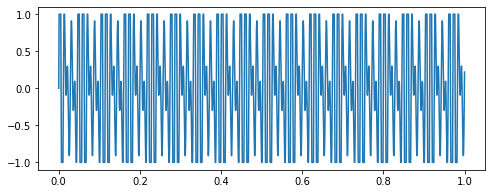

In [25]:
root = a
m3rd = root * 5/4
p5th = root * 3/2

# Chord?
t = t_space(1.0)
o = sin(root)(t) \
  + sin(m3rd)(t) \
  + sin(p5th)(t)

# Play audio
o = aclip(o)
plt.plot(t, o)
play(o)

Well... this is kinda bad... 

I found this [Wikipedia Article](https://en.wikipedia.org/wiki/Interval_(music)) on musical intervals. Going to read it.

So, pianos and other instruments are tuned using "cents". The "distance" in cents (labeled $n$) between two frequencies $f_2$ and $f_1$ defined using logarithms with this formula:.

$$
n = 1200 \log_2{ \left( \frac{f_2}{f_1} \right) }
$$

I'm actually intrigued by calling this a "distance" formula, since that is an abstraction that has multiple other uses in mathematics and physics. I might want to examine this more

Actually, I just remembered, we use a similar measurement in engineering (the decibel, or dB, which is a logarithmic measure of signal strength)